<a href="https://colab.research.google.com/github/VickkiMars/CV_Mastery/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: victorthamartian
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:03<00:00, 28.0MB/s]


In [6]:
import zipfile

In [8]:
import tensorflow as tf
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_path = '/content/brain-tumor-classification-mri/Training'
test_path = '/content/brain-tumor-classification-mri/Testing'

In [12]:
train = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred', # Labels are inferred from subdirectory names
    label_mode='categorical', # Use categorical labels for multi-class classification
    image_size=(224, 224),  # Resize images to a consistent size
    interpolation='nearest',  # Interpolation method for resizing
    batch_size=32,  # Adjust batch size as needed
    shuffle=True  # Shuffle the dataset
)

test = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels='inferred', # Labels are inferred from subdirectory names
    label_mode='categorical', # Use categorical labels for multi-class classification
    image_size=(224, 224),  # Resize images to a consistent size
    interpolation='nearest',  # Interpolation method for resizing
    batch_size=32,  # Adjust batch size as needed
    shuffle=True  # Shuffle the dataset
)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [14]:
train.class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [17]:
from keras import layers
aug_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [18]:
def augment_image(image, label):
  image = aug_layer(image)
  return image, label

In [19]:
train = train.map(augment_image)

In [31]:
for images, labels in train.take(1):  # Take one batch from the dataset
    print("Image shape:", images.shape)
    print("Image data type:", images.dtype)
    print("Label shape:", labels.shape)
    print("Label data type:", labels.dtype)
    # Access individual image and label:
    image = images[0]  # Get the first image in the batch
    label = labels[0]  # Get the corresponding label
    print("Shape of a single image:", image.shape)
    # You can access other properties like image.ndim, image.size, etc.

Image shape: (32, 224, 224, 3)
Image data type: <dtype: 'float32'>
Label shape: (32, 4)
Label data type: <dtype: 'float32'>
Shape of a single image: (224, 224, 3)


In [35]:
import matplotlib.pyplot as plt
import random
import numpy as np

def plot_random_images(dataset, label_names, num_images=3):
  """Plots a specified number of random images from the dataset.

  Args:
    dataset: The TensorFlow dataset to sample images from.
    label_names: A list of label names corresponding to the dataset classes.
    num_images: The number of random images to plot. Defaults to 3.

  Returns:
    None
  """
  plt.figure(figsize=(10, 5))  # Adjust figure size as needed
  for i in range(num_images):
    # Get a random element from the dataset
    random_element = random.choice(list(dataset.as_numpy_iterator()))
    image, label = random_element
    image = image[0]

    # Plot the image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.astype("uint8"))  # Convert image to uint8 for display
    plt.title(f"Label: {label_names[np.argmax(label)]}")
    plt.axis("off")

  plt.show()

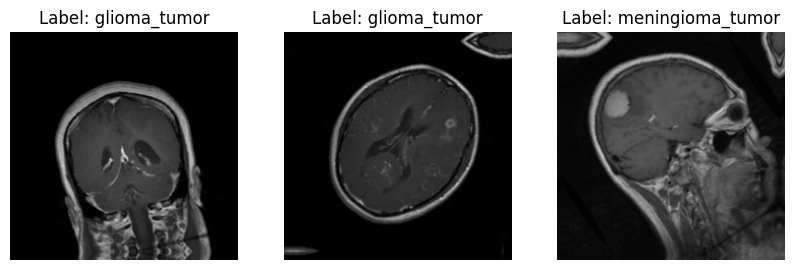

In [36]:
plot_random_images(train, ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [38]:
class BraiNN(layers.Layer):
  def __init__(self, num_classes):
    super(BraiNN, self).__init__()
    self.conv1 = layers.Conv2D(32, (3, 3), activation='relu')
    self.pool1 = layers.MaxPooling2D((2, 2))
    self.dropout1 = layers.Dropout(0.5)

    self.conv2 = layers.Conv2D(64, (3, 3), activation='relu')
    self.pool2 = layers.MaxPooling2D((2, 2))
    self.dropout2 = layers.Dropout(0.5)

    self.flatten = layers.Flatten()
    self.dense1 = layers.Dense(128, activation='relu')
    self.dense2 = layers.Dense(num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.dropout1(x)

    x = self.conv2(x)
    x = self.pool2(x)
    x = self.dropout2(x)

    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x

In [39]:
BraiNN = BraiNN(num_classes=4)

In [40]:
# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='optim_var.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max'
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    mode='min'
)

callbacks = [
    checkpoint,
    early_stopping,
    tensorboard,
    reduce_lr
]

In [41]:
inputs = keras.Input(shape=(224, 224, 3))

model = tf.keras.models.Model(
    inputs = inputs,
    outputs = BraiNN(inputs)
)

In [ ]:
optim = keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
loss_fn = keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optim, loss=loss_fn, metrics=['accuracy'])
history = model.fit(train, epochs=100, callbacks=callbacks)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.3530 - loss: 532.9999

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 629ms/step - accuracy: 0.3535 - loss: 528.8986 - learning_rate: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 526ms/step - accuracy: 0.4399 - loss: 1.2909 - learning_rate: 0.0010
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 517ms/step - accuracy: 0.4334 - loss: 1.2569 - learning_rate: 0.0010
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.4697 - loss: 1.2056 - learning_rate: 0.0010
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 518ms/step - accuracy: 0.4842 - loss: 1.1582 - learning_rate: 0.0010
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 510ms/step - accuracy: 0.4847 - loss: 1.1573 - learning_rate: 0.0010
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - accuracy: 0.5062 - loss: 1.1264 - learning_rate: 0.0010
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 523ms/step - accuracy: 0.5094 - loss: 1.1450 - learning_rate: 0.0010
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 517ms/step - accuracy: 0.4967 - loss: 1.1093 - learning_rate: 0.0010
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 519ms/step - accuracy: 0.5150 - loss: 1.0962 - learning_rate: 0.0010
Epo